In [10]:
%matplotlib inline
import sys
import string
import copy
from collections import Counter
from operator import itemgetter
import numpy as np
from math import exp
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import defaultdict
from math import log
from scipy import stats

In [4]:
def process_str(s):
    return s.translate(str.maketrans('', '', string.punctuation)).lower().split()

def read_dataset(file_name):
    dataset = []
    with open(file_name) as f:
        for line in f:
            try:
                index, class_label, text = line.strip().split('\t')
                words = process_str(text)
                dataset.append( (int(class_label), set(words)) )
            except ValueError:
                pass
    return dataset

def get_most_commons(dataset, skip=100, total=4000):
    my_list = []
    for item in dataset:
        my_list += list(item[1])

    counter = Counter(my_list)

    temp = counter.most_common(total+skip)[skip:]
    words = [item[0] for item in temp]
    return words

def generate_vectors(dataset, common_words, ternary, bias_term):
    d = {}
    for i in range(len(common_words)):
        d[common_words[i]] = i

    vectors = []
    for item in dataset:
        vector = [0] * len(common_words)
        for word in item[1]:
            if word in d:
                if vector[d[word]] is 1 and ternary:
                    vector[d[word]] = 2
                vector[d[word]] = 1

        if bias_term:
            vector.append(1.0)

        vectors.append( (item[0], np.array(vector)) )

    return vectors

def random_sample(data, proportion):
    
    count = int(len(data) * proportion)
    np.random.shuffle(data)
    return data[:count]

In [5]:
def lr_train(train_vectors, iterations=100, reg=0.01,
        lr=0.01, stop_diff=int(1e-6)):

    count_w = len(train_vectors[0][1])
    w = np.zeros((count_w, ))

    for i in range(iterations):
        grad = np.zeros((count_w, ))

        for vector in train_vectors:

            y = vector[0]
            x = vector[1]

            y_hat = lr_calc_prob(w, x)

            grad += (y - y_hat)*x

        grad -= reg * w

        w += lr * grad

        if np.linalg.norm(grad) <= stop_diff:
            break

    return w

def lr_calc_prob(w, x):

    denominator = 1 + exp(-1 * np.dot(w, x))

    pred = 1 / denominator

    return pred

def lr_classify(w, x):

    prob = lr_calc_prob(w, x)

    if prob >= 0.5:
        return 1
    else:
        return 0

def lr_train_test(train_vectors, test_vectors):

    w = lr_train(train_vectors)
    incorrect = 0.0

    for vector in test_vectors:
        y = vector[0]
        x = vector[1]

        y_hat = lr_classify(w, x)

        if y_hat is not y:
            incorrect += 1

    return incorrect/len(test_vectors)

In [11]:
DATA_SIZE = 300
def main(sample, model):
    train_data_file = 'tests/yelp_train' + str(sample) + '.txt'
    test_data_file = 'tests/yelp_test' + str(sample) + '.txt'

    train_data = read_dataset(train_data_file)
    test_data = read_dataset(test_data_file)

    common_words = get_most_commons(train_data, total=500)

    ternary = False
    bias_term = True
    
    train_vectors = generate_vectors(train_data, common_words, ternary, True)
    test_vectors = generate_vectors(test_data, common_words, ternary, True)
    
    zero_one_loss = 0
    if model is 1:
        zero_one_loss = lr_train_test(train_vectors, test_vectors)
        print('ZERO-ONE-LOSS-LR ' + str(zero_one_loss))

    elif model is 2:
        zero_one_loss = svm_train_test(train_vectors, test_vectors)
        print('ZERO-ONE-LOSS-SVM ' + str(zero_one_loss))

    else:
        print('usage: python nbc.py train.csv test.csv model')
        print('exiting...')

main(1, 1)

ZERO-ONE-LOSS-LR 0.11


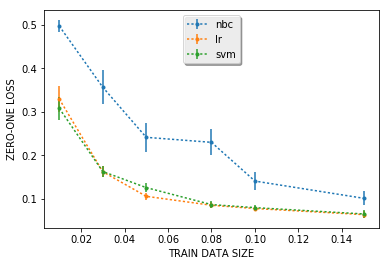

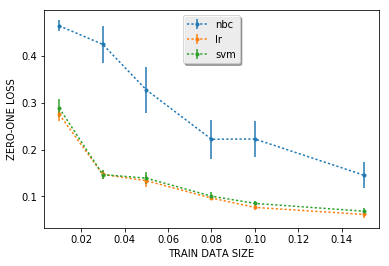

In [18]:
def parse_results(data):
    
    nbc = []
    lr = []
    svm = []
    for row in data:
        
        nbc_data = np.array([item[0] for item in row])
        lr_data  = np.array([item[1] for item in row])
        svm_data = np.array([item[2] for item in row])
        
        nbc_mean = np.mean(nbc_data)
        lr_mean  = np.mean(lr_data)
        svm_mean = np.mean(svm_data)
        
        nbc_se = stats.sem(nbc_data)
        lr_se  = stats.sem(lr_data)
        svm_se = stats.sem(svm_data)
        
        nbc.append([nbc_mean, nbc_se])
        lr.append( [lr_mean , lr_se])
        svm.append([svm_mean, svm_se])
        
    return nbc, lr, svm

def create_graphs(result_list, flag):
    
    results = parse_results(result_list)

    names = ['nbc', 'lr', 'svm']
    colors = ['r', 'g', 'b']
    train_sizes = [0.01, 0.03, 0.05, 0.08, 0.1, 0.15]
    for i, item in enumerate(results):
        y_axis = [row[0] for row in item]
        y_err = [row[1] for row in item]
        
        plt.errorbar(train_sizes, y_axis, yerr=y_err, marker='.', ls=':', label=names[i])
        plt.xlabel('TRAIN DATA SIZE')
        plt.ylabel('ZERO-ONE LOSS')
        plt.legend(loc='upper center', shadow=True)
        
        
    if flag is True:
        #plt.savefig('analysis2.png')
        pass
    else:
        #plt.savefig('analysis1.png')
        pass
    plt.show()
        
        

create_graphs(result_list, False)
create_graphs(rich_result_list, True)